# 딥러닝 기반의 검색 빈도수를 이용한 주가예측

# 0. Install packages

In [1]:
!pip install finance-datareader
!pip install -U finance-datareader # 업데이트

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 1.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import json
import re

# 1. Prepare datasests

## 1-1. 주가 데이터 불러오기

In [3]:
# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

# 한국거래소에 상장된 모든 종목 리스트 가져오기
import FinanceDataReader as fdr
df_krx = fdr.StockListing('KRX')
df_krx.head()

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,전자부품 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,김세완,http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,"박대현, 손삼달",http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도


In [4]:
df = fdr.DataReader('003490','2020-01-01', '2022-05-27') # NCsoft 주가를 2020년부터 현시점까지 가져온다

In [5]:
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,18479,18511,17993,18058,303459,-0.022835
2020-01-03,18155,18252,17668,17701,572272,-0.019770
2020-01-06,17409,17571,16858,17183,690224,-0.029264
2020-01-07,17182,17604,17117,17410,388103,0.013211
2020-01-08,17150,17312,16826,17053,676198,-0.020505
...,...,...,...,...,...,...
2022-05-23,28950,28950,28600,28750,1001628,-0.001736
2022-05-24,28850,29150,28550,28650,1024749,-0.003478
2022-05-25,28550,28700,28400,28500,988866,-0.005236


In [6]:
df = df.fillna(0)

(array([737425., 737516., 737607., 737699., 737791., 737881., 737972.,
        738064., 738156., 738246., 738337.]),
 <a list of 11 Text major ticklabel objects>)

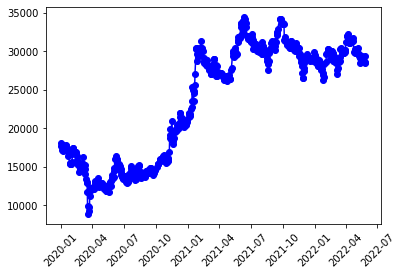

In [7]:
plt.plot(df['Close'], 'bo-')
plt.xticks(rotation=45)

## 1-2. Naver API 키워드 검색 데이터 불러오기

In [8]:
import os
import sys
import urllib.request
client_id = "8y4FUmFdq2Ojofq_vHAA"
client_secret = "dC9XGv5tQR"
url = "https://openapi.naver.com/v1/datalab/search";
body = "{\"startDate\":\"2020-01-01\",\"endDate\":\"2022-05-27\",\"timeUnit\":\"date\",\"keywordGroups\":[{\"groupName\":\"KoreaAir_N\",\"keywords\":[\"국제유가\",\"입국금지\"]}, {\"groupName\":\"KoreaAir_P\",\"keywords\":[\"항공주\",\"여행\",\"해외여행\",\"일본여행\",\"대한항공\"]}]}";

request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
request.add_header("Content-Type","application/json")
response = urllib.request.urlopen(request, data=body.encode("utf-8"))
rescode = response.getcode()
if(rescode==200):
    response_body = response.read()
    #print(response_body.decode('utf-8'))
    search_count = response_body.decode('utf-8')
else:
    print("Error Code:" + rescode)

In [9]:
search_count_json = json.loads(search_count)

In [10]:
search_count_json

{'endDate': '2022-05-27',
 'results': [{'data': [{'period': '2020-01-01', 'ratio': 0.57919},
    {'period': '2020-01-02', 'ratio': 0.82122},
    {'period': '2020-01-03', 'ratio': 2.37845},
    {'period': '2020-01-04', 'ratio': 2.01335},
    {'period': '2020-01-05', 'ratio': 1.15455},
    {'period': '2020-01-06', 'ratio': 3.38853},
    {'period': '2020-01-07', 'ratio': 13.2714},
    {'period': '2020-01-08', 'ratio': 5.73139},
    {'period': '2020-01-09', 'ratio': 6.99767},
    {'period': '2020-01-10', 'ratio': 2.06709},
    {'period': '2020-01-11', 'ratio': 1.30626},
    {'period': '2020-01-12', 'ratio': 0.74522},
    {'period': '2020-01-13', 'ratio': 1.38538},
    {'period': '2020-01-14', 'ratio': 1.60642},
    {'period': '2020-01-15', 'ratio': 1.43018},
    {'period': '2020-01-16', 'ratio': 1.3841},
    {'period': '2020-01-17', 'ratio': 1.23041},
    {'period': '2020-01-18', 'ratio': 0.75996},
    {'period': '2020-01-19', 'ratio': 0.37247},
    {'period': '2020-01-20', 'ratio': 0.8359

## 1-3. 데이터 전처리 및 Merge하기

In [11]:
for idx in range(len(search_count_json["results"])):
  
  df_json = pd.DataFrame(search_count_json["results"][idx]["data"])
  column_name = 'Key_Count'+str(idx)
  df_json.columns = ['Date', column_name]
  df_json['Date'] = pd.to_datetime(df_json['Date'])
  df_json.reset_index(drop=True)
  df_json.set_index("Date")
  #Please refer to the section of "Merging asof" in https://pandas.pydata.org/docs/user_guide/merging.html
  df = pd.merge_asof(df, df_json, on="Date", by="Date")

In [12]:
df_all = df

In [13]:
df_all["Change"].sum() # 전체 주가의 변동폭은 2020년부터 현재까지 증가일까 감소일까? 최종 주가는 빠졌는데 놀랍게도 증가함.. 이는 복리의 함정

0.6982597774796164

In [14]:
df_all[df_all["Date"] > '2022-01-01']["Change"].sum() #조금 더 범위를 좁혀 그러면 2022년 전체 주가 변동폭만 검색해보자, 역시 폭락중 불쌍한 임교수

0.018551362996579557

In [15]:
#df_all[df_all["Count"].notnull()]["Change"].sum() # 그렇다면 해당 키워드가 검색된 날만 뽑아 주가가 상승했는지 하락인지 살펴보자.

In [16]:
# Fill nan as 0
df_all = df_all.fillna(0)
df_all.any().isnull()

Date          False
Open          False
High          False
Low           False
Close         False
Volume        False
Change        False
Key_Count0    False
Key_Count1    False
dtype: bool

In [17]:
df_all

,Date,Open,High,Low,Close,Volume,Change,Key_Count0,Key_Count1
0,2020-01-02,18479,18511,17993,18058,303459,-0.022835,0.82122,13.51257
1,2020-01-03,18155,18252,17668,17701,572272,-0.019770,2.37845,12.48860
2,2020-01-06,17409,17571,16858,17183,690224,-0.029264,3.38853,14.22093
3,2020-01-07,17182,17604,17117,17410,388103,0.013211,13.27140,14.24291
4,2020-01-08,17150,17312,16826,17053,676198,-0.020505,5.73139,13.63054
...,...,...,...,...,...,...,...,...,...
590,2022-05-23,28950,28950,28600,28750,1001628,-0.001736,5.22918,14.17641
591,2022-05-24,28850,29150,28550,28650,1024749,-0.003478,5.97980,13.40467
592,2022-05-25,28550,28700,28400,28500,988866,-0.005236,5.74089,12.88106
593,2022-05-26,28550,28800,28450,28600,953524,0.003509,5.63313,13.25920


## 1-4. Feature Selection

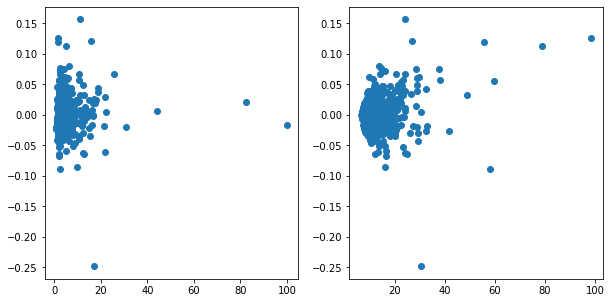

In [18]:
## You need to visualized a relational graph
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(df_all["Key_Count0"], df_all["Change"])
ax2.scatter(df_all["Key_Count1"], df_all["Change"])


# 2. Define Model

In [19]:
input_size = 2 # x0의 dimension = feature의 개수 = 2
hidden_size = 10 # 임의로 지정
rnn = torch.nn.RNN(2, 10) # rnn = torch.nn.RNN(input_size, hidden_size)
input = torch.randn(1, 5, 2) # (batchsize, seq, input_size)
output, _ = rnn(input) # output (b, s, hidden_size)

In [20]:
class RNNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layer=1):
        super(RNNModel, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers = num_layer ,batch_first=True)
        #self.relu = torch.nn.ReLU()
        self.linear_classifier = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _ = self.rnn(x.unsqueeze(0))
        #x = self.relu(x)
        x = self.linear_classifier(x[:,-1])
        return x

# 3. Define the loss function and the optimizer

In [21]:
input_dim = 2
hidden_dim = 10
sequence_size = 5
output_dim = 1
layer_size = 1

learning_rate = 0.001
model = RNNModel(input_dim, hidden_dim, output_dim)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.MSELoss()

# 4. Define train function

In [22]:
def train(train_x, train_y, loss_function, optimizer, model):
  total_loss = []

  for idx in range(len(train_x)):
    model.train()
    optimizer.zero_grad()
    train_x_tensor = torch.tensor(train_x[idx]).float() #convert numpy to torch tensor
    train_y_tensor = torch.tensor(train_y[idx]).float()
    logit = model(train_x_tensor)
    loss = loss_function(logit, train_y_tensor)
    total_loss.append(loss.item())

    loss.backward()
    optimizer.step()

  return total_loss

# 5. Training 

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['Scaled_Key_Count0','Scaled_Key_Count1']] = scaler.fit_transform(df[['Key_Count0','Key_Count1']])

In [24]:
df_all = df

In [25]:
df_all.head()

,Date,Open,High,Low,Close,Volume,Change,Key_Count0,Key_Count1,Scaled_Key_Count0,Scaled_Key_Count1
0,2020-01-02,18479,18511,17993,18058,303459,-0.022835,0.82122,13.51257,0.000000,0.078113
1,2020-01-03,18155,18252,17668,17701,572272,-0.019770,2.37845,12.48860,0.015701,0.067014
2,2020-01-06,17409,17571,16858,17183,690224,-0.029264,3.38853,14.22093,0.025886,0.085792
3,2020-01-07,17182,17604,17117,17410,388103,0.013211,13.27140,14.24291,0.125533,0.086030
4,2020-01-08,17150,17312,16826,17053,676198,-0.020505,5.73139,13.63054,0.049508,0.079392


In [ ]:
'''
x_scaled = df_all[['Scaled_Key_Count0','Scaled_Key_Count1']].to_numpy()
y_scaled = df_all["Change"].to_numpy()

train_x, test_x, train_y, test_y = train_test_split(x_scaled, y_scaled, test_size=0.2)
'''

'\nx_scaled = df_all[[\'Scaled_Key_Count0\',\'Scaled_Key_Count1\']].to_numpy()\ny_scaled = df_all["Change"].to_numpy()\n\ntrain_x, test_x, train_y, test_y = train_test_split(x_scaled, y_scaled, test_size=0.2)\n'

In [26]:
seq_x = []
seq_y = []

feature_list = ['Scaled_Key_Count0','Scaled_Key_Count1']
df_all[feature_list][0:5]
x = df_all[feature_list][1:6]
y = df_all["Change"][6]
#print(y)

In [27]:
s_idx = 0
e_idx = len(df_all)
date_interval = 1
num_days = 4
y_days = 5

In [28]:
y_days = 5
for idx in range(s_idx, e_idx, date_interval):
    if idx == 590:
        break
    x = df_all.loc[idx:idx+num_days][feature_list].to_numpy().tolist()
    y = df_all.loc[y_days+idx]["Change"].tolist()

    seq_x.append(x) if len(x) == 5 else None
    seq_y.append(y) if len(x) == 5 else None
    #x = df_all.loc[idx:idx+num_days][feature_list].to_numpy().tolist()
    #y = df_all.loc[idx:idx+num_days]["Change"].sum().tolist()

    #seq_x.append(x) if len(x) == 5 else None
    #seq_y.append(y) if len(x) == 5 else None

In [30]:
seq_y

[0.043745968451298856,
 -0.0055059272992864505,
 0.0,
 -0.005423422405513856,
 -0.0018744674808293116,
 0.014796266788071888,
 -0.0036451323463436713,
 -0.020093431642933535,
 -0.02607696726019526,
 0.013387591413069222,
 -0.04149450037828084,
 -0.066909532483303,
 0.006246746486205046,
 -0.0020046559751680793,
 -0.006350029158297188,
 0.02112813824584281,
 0.06628775783894247,
 0.009702341738036857,
 0.038495758941811564,
 -0.003769705277587354,
 -0.022302488246760732,
 -0.007564651380988718,
 0.0,
 -0.0019498936421650237,
 -0.015333609614587629,
 -0.013648388648388687,
 -0.033587320938738174,
 -0.010218241453261001,
 -0.022750446087178133,
 -0.0041734594065862,
 -0.061620064173924405,
 0.01584089323098392,
 0.022257333241739286,
 0.0,
 -0.028291109468449704,
 0.0,
 0.004495159059474396,
 0.07139414802065414,
 0.045880992160390655,
 -0.051794052592774587,
 -0.016847016134257764,
 0.006458841362947387,
 -0.033985986510379096,
 -0.04616323210412143,
 -0.05067159405870225,
 -0.0242551280

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(seq_x, seq_y, test_size=0.2)

In [ ]:
train_x[0]

[[0.011120826450980741, 0.03879536907550721],
 [0.011531095663810343, 0.03594892641340312],
 [0.007468129775341054, 0.044291402277609415],
 [0.01962113266567707, 0.03675736425848375],
 [0.05384569158846277, 0.03828665376215733]]

In [ ]:
best_model = None
num_epoch = 500
loss_epoch = []

for epoch in range(num_epoch):
  loss_list = train(train_x, train_y, loss_function, optimizer, model)
  loss_epoch.append(sum(loss_list)/len(train_x))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


<BarContainer object of 500 artists>

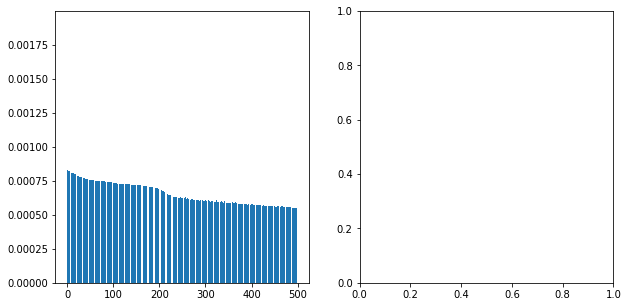

In [ ]:
## You need to visualized a relational graph
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.bar(range(num_epoch), loss_epoch)
#ax2.scatter(train_x[-1], train_y)
#x = np.linspace(0,1,100)
#linear_weight = model.linear_classifier.weight.detach().numpy()
#lienar_bias = model.linear_classifier.bias.detach().numpy()
#y = linear_weight*x+lienar_bias
#y = y.reshape((100))
#ax2.plot(x, y, '-r', label='y='+str(linear_weight[-1][-1])+'x+'+str(lienar_bias[-1]))
#ax2.legend(loc='upper left')

In [ ]:
loss_epoch

[0.001903757970379738,
 0.0008266303363576343,
 0.0008269706338920982,
 0.000825351518026204,
 0.0008230712283806111,
 0.0008206568061934288,
 0.0008183192574210013,
 0.0008161313470083722,
 0.0008141072025905705,
 0.0008122368330864367,
 0.0008105018211481383,
 0.0008088817957366202,
 0.0008073560086307168,
 0.0008059042386770948,
 0.0008045046484332992,
 0.0008031289886726244,
 0.0008017381870505858,
 0.0008002838786018234,
 0.0007987149649738276,
 0.0007969840206842054,
 0.0007950548756967763,
 0.0007929168867810069,
 0.0007906043310736853,
 0.000788211924518555,
 0.0007858852734125443,
 0.0007837675749481596,
 0.0007819286103158492,
 0.0007803456166722675,
 0.0007789514032133737,
 0.0007776842475140747,
 0.0007765040018981251,
 0.0007753865022784423,
 0.0007743152233862765,
 0.000773278706402582,
 0.0007722675957346466,
 0.000771272728167191,
 0.0007702849575324456,
 0.000769296382005886,
 0.0007683008404421815,
 0.0007672944260817185,
 0.0007662754605058495,
 0.0007652447088609379

# 6. Evaluation

In [ ]:
x_predicted = []
for idx in range(len(test_x)):
  predicted = model(torch.tensor(test_x[idx]).float())
  x_predicted.append(predicted.detach())
x_pred_np = np.array(x_predicted)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


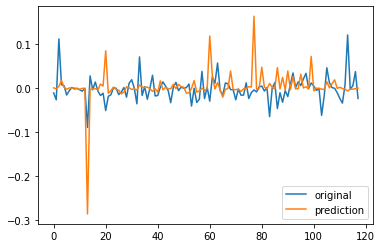

In [ ]:
plt.plot(test_y)
plt.plot(x_pred_np)
plt.legend(['original', 'prediction'])
plt.show()

# 7. Prediction

In [ ]:
def predict(key_count, model):
  model.eval()
  logit = model(key_count)
  return logit

In [ ]:
raw_input = [[10,20], [15, 1.1], [15, 1.1], [15, 1.1], [15, 1.1]]
scaled_input = []
for a_day in raw_input:
    key_count = np.array(a_day)
    scaled = scaler.transform(key_count.reshape(1,-1)).tolist()[0]
    scaled_input.append(scaled)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature na

In [ ]:
df_all.max()
predicted = predict(torch.FloatTensor(scaled_input), model)

In [ ]:
print("검색량이"+str(raw_input)+"일때 주가는", str(predicted.item()*100) )

검색량이[[10, 20], [15, 1.1], [15, 1.1], [15, 1.1], [15, 1.1]]일때 주가는 1.8987953662872314
